# Model engineering 006: XGBoost Regression

In this part of the project to predict the photovoltaic production of solar cells on a roof we are considering a XGBoost regression model. 

We will treat this as a regression problem, not taking the temporal aspect, i.e. time series forcasting, into account. Data mining and missing value treatment of weather data from the DarkSky API and data from the photovoltaic system were covered in other notebooks:

- Data mining and EDA of weather data: https://kyso.io/heiko/predicting-solar-panel-output-eda-of-photovoltaic-data

- Data mining and EDA of photovoltaic data: https://kyso.io/heiko/predicting-solar-panel-output-eda-of-weather-data

- Missing value treatment: https://kyso.io/heiko/predicting-solar-panel-output-missing-value-treatment-of-weather-data

## Methodology

We will apply XGBoost regression by following these steps:

1. Load the data into one dataframe

2. Select the features we will use for the prediction. We can look at the correlation matrix and remove redundant features that are correlated. Multicollinearity undermines the statistical significance of an independent variable. While it should not have a major impact on the model’s accuracy, it does affect the variance associated with the prediction, as well as, reducing the quality of the interpretation of the independent variables. In other words, the effect your data has on the model isn’t trustworthy. Your explanation of how the model takes the inputs to produce the output will not be reliable. (You can read more about this here: https://towardsdatascience.com/multicollinearity-why-is-it-a-problem-398b010b77ac). We will just drop (one of the) columns that are correlated. We could feature engineer another features that combines the correlated features, but at this point this will not be considered.

3. Consider missing values. This is still part of the feature selection process. We remove features that have lots of missing values that we could not interpolate.

4. Model selection. We will use RandomizedSearch and GridSearch approach to tune hyperparameters of the XGBoost model.

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV

import eli5
sns.set()
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Load dataset

This is the cleaned dataset from the MultiLinear model.

In [33]:
data = pd.read_csv('../02.Prepared_data/dataset.Model_eng.001.csv')

# Feature selection

Select the features in a pipeline as for the linear model.

In [34]:
# X = df_cleaned.iloc[:, 1:].values
X = data.iloc[:, 1:]
X = X.reset_index(drop=True)
# y = df_cleaned.iloc[:, 0].values
y = data.iloc[:, 0]
y = y.reset_index(drop=True)

### Numeric features: StandardScaler

Standardize features by removing the mean and scaling to unit variance

In [4]:
numeric_features = ['apparentTemperatureHigh', 'precipProbability', 'uvIndex', 'precipIntensityMax_cm', 'sun_uptime']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

### Categorical features: OneHotEncoder

This preprocessing step will encode the `season` and `precipType` column values into a vector of length 3. For example, winter will be encoded as [1,0,0], summer as [0,1,0], and so on for the other seasons.

In [35]:
categorical_features = ['season', 'precipType']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [36]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', xgb.XGBRegressor(random_state = 0))])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Randomized and GridSearch to tune the hyperparameters

The idea behind a XGBoost is similar to the RandomForest algorithm, to get N estimators from one estimator (one tree). However, in the sampling process that is called boosting, the dataset is repeatedly sampled (with or without replacement). Then in a sequential operation, a decision tree is fitted on each of the individual datasets. For each new step (next dataset), the previous classifiers' success is considered, because after each training step, the weights are redistributed. Data with higher errors (according to the objective of the algorithm) receive higher weights. In the final step, the average of all the individual trees outcome is taken as the regression value. In this step, the weight of each individual estimator is taken into account. An estimator with a low error will be assigned a higher weight. 
This tackles the problem of overfitting of a single tree, that can happen with a single DecisionTree alone. 

To tune the hyperparameters, first there will be a randomized search to find where the improved parameters may lie. That limits the feature space for the grid search. In a second step, a grid search around these parameters is performed.

Grid Search is as an exhaustive search for selecting a model. Every combination of hyperparameter values is tried which can be very inefficient. By contrast, Random Search sets up a grid of hyperparameter values and selects random combinations to train the model and score. This allows control of the number of parameter combinations that are attempted. 

In [44]:
# first access the parameter keys of the individual estimators
list(clf.get_params().keys())

['memory',
 'steps',
 'verbose',
 'preprocessor',
 'classifier',
 'preprocessor__n_jobs',
 'preprocessor__remainder',
 'preprocessor__sparse_threshold',
 'preprocessor__transformer_weights',
 'preprocessor__transformers',
 'preprocessor__verbose',
 'preprocessor__num',
 'preprocessor__cat',
 'preprocessor__num__memory',
 'preprocessor__num__steps',
 'preprocessor__num__verbose',
 'preprocessor__num__scaler',
 'preprocessor__num__scaler__copy',
 'preprocessor__num__scaler__with_mean',
 'preprocessor__num__scaler__with_std',
 'preprocessor__cat__memory',
 'preprocessor__cat__steps',
 'preprocessor__cat__verbose',
 'preprocessor__cat__onehot',
 'preprocessor__cat__onehot__categories',
 'preprocessor__cat__onehot__drop',
 'preprocessor__cat__onehot__dtype',
 'preprocessor__cat__onehot__handle_unknown',
 'preprocessor__cat__onehot__sparse',
 'classifier__objective',
 'classifier__base_score',
 'classifier__booster',
 'classifier__colsample_bylevel',
 'classifier__colsample_bynode',
 'classi

In [45]:
# gamma Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.
gamma = [0, 0.1, 10, 100, 1000, 10000]
# Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.
max_depth = [1, 6, 10, 15, 20]
# Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the 
# sum of instance weight less than min_child_weight, then the building process will give up further partitioning. In linear regression task, 
# this simply corresponds to minimum number of instances needed to be in each node. The larger min_child_weight is, the more conservative the algorithm will be.
min_child_weight = [1, 5, 10, 15, 20, 100]
# Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. 
# and this will prevent overfitting. Subsampling will occur once in every boosting iteration.
subsample = [0.1, 0.25, 0.5, 0.75, 1]
# lambda L2 regularization term on weights. Increasing this value will make model more conservative.
l2 = [0, 1, 10, 100, 1000] 
# alpha L1 regularization term on weights. Increasing this value will make model more conservative.
l1 = [0, 1, 10, 100, 1000] 
# objective Specify the learning task and the corresponding learning objective.
objective = ['reg:squarederror', 'reg:squaredlogerror']


# Create the random grid
random_grid = {'classifier__gamma': gamma,
               'classifier__max_depth': max_depth,
               'classifier__min_child_weight': min_child_weight,
               'classifier__reg_alpha': l1,
               'classifier__objective': objective,
               'classifier__subsample': subsample,
               'classifier__reg_lambda': l2}


# Use the random grid to search for best hyperparameters
# First create the base model to tune
# clf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
clf_random = RandomizedSearchCV(estimator=clf, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
# Fit the random search model
clf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 277 out of 300 | elapsed:    4.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    4.6s finished


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['apparentTemperatureHigh',
                                                                                'precipProbability',
                                                                                'uvIndex',
                                                                                'precipIntensityMax_cm',
                                                                                'sun_uptime']),
                                                                              ('cat',
                  

In [39]:
clf_random.best_params_

{'classifier__subsample': 0.75,
 'classifier__reg_lambda': 100,
 'classifier__reg_alpha': 10,
 'classifier__objective': 'reg:squarederror',
 'classifier__min_child_weight': 20,
 'classifier__max_depth': 6,
 'classifier__gamma': 10}

In [40]:
# gamma Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.
gamma = [5, 10, 15]
# Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.
max_depth = np.arange(2,11,2, dtype=int)
# Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the 
# sum of instance weight less than min_child_weight, then the building process will give up further partitioning. In linear regression task, 
# this simply corresponds to minimum number of instances needed to be in each node. The larger min_child_weight is, the more conservative the algorithm will be.
min_child_weight = np.arange(15,28,2, dtype=int)
# Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. 
# and this will prevent overfitting. Subsampling will occur once in every boosting iteration.
subsample = [0.7, 0.75, 0.9]
# lambda L2 regularization term on weights. Increasing this value will make model more conservative.
l2 = [75, 100, 125] 
# alpha L1 regularization term on weights. Increasing this value will make model more conservative.
l1 = [7,10,12] 
# objective Specify the learning task and the corresponding learning objective.
objective = ['reg:squarederror', 'reg:linear']


# Create the random grid
param_grid = {'classifier__gamma': gamma,
               'classifier__max_depth': max_depth,
               'classifier__min_child_weight': min_child_weight,
               'classifier__reg_alpha': l1,
               'classifier__objective': objective,
               'classifier__subsample': subsample,
               'classifier__reg_lambda': l2}


# Instantiate the grid search model
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, 
                          cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 5670 candidates, totalling 17010 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 432 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1244 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 2376 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 3836 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 4698 tasks      | elapsed:   57.3s
[Parallel(n_jobs=-1)]: Done 5225 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 5832 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 6521 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 7290 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 8141 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 9072 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 10085 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 11178 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 12353 tasks  

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['apparentTemperatureHigh',
                                                                          'precipProbability',
                                                                          'uvIndex',
                                                                          'precipIntensityMax_cm',
                                                                          'sun_uptime']),
                                                                        ('cat',
                                                                         Pipeline(st

In [41]:
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['apparentTemperatureHigh',
                                                   'precipProbability',
                                                   'uvIndex',
                                                   'precipIntensityMax_cm',
                                                   'sun_uptime']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['season', 'precipType'])])),
                ('classifier',
                 XGBRegressor(base_score=0.5, booster=None

### Evaluate the model: r2 score and MSE

In [42]:
y_pred = best_model.predict(X_test)
r2_score(y_test, y_pred)

0.7852497173370512

In [43]:
mean_squared_error(y_test, y_pred)

41.81744348763667

Feature: 0, Score: 0.15721
Feature: 1, Score: 0.10116
Feature: 2, Score: 0.07016
Feature: 3, Score: 0.09909
Feature: 4, Score: 0.25607
Feature: 5, Score: 0.13049
Feature: 6, Score: 0.04849
Feature: 7, Score: 0.02599
Feature: 8, Score: 0.04866
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.01973
Feature: 11, Score: 0.04295


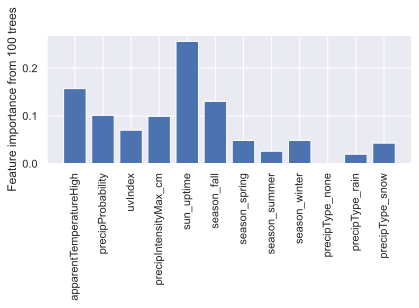

In [48]:
importance = best_model.named_steps['classifier'].feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
# get feature names
onehot_columns = list(best_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names(input_features=categorical_features))
numeric_features_list = list(numeric_features)
numeric_features_list.extend(onehot_columns)


# plot feature importance
fig, ax = plt.subplots(figsize=(6,4))
plt.bar([x for x in range(len(importance))], importance, align='center')
plt.xticks(np.arange(0, len(importance)), numeric_features_list, rotation=90)
plt.ylabel('Feature importance from 100 trees')
plt.tight_layout()
plt.savefig('xgboost.png', dpi=200)
plt.show()

It seems that `apparentTemperatureHigh` and `sun_uptime` are important parameters, as we saw with the random forest regressor. We could further investigate the importance of parameters using permutation tests for example, some techniques are illustrated in https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e.

# Conclusion

We applied XGboost Regression to the dataset, predicting the solar panel output values for different weather conditions.
For the model with 100 trees, we found a MSE (root mean squared error) of 41.8 and an r2_score of 0.79.

We also found that `apparentTemperatureHigh` and `sun_uptime` are important parameters, same as with the 1500 random forest regressor model.
